<img src="https://www.th-koeln.de/img/logo.svg" style="float:right;" width="200">

# 5th exercise: <font color="#C70039">Work with Robust Random Cut Forest (RRCF) algorithms for anomaly detection</font>
* Course: AML
* Lecturer: <a href="https://www.gernotheisenberg.de/">Gernot Heisenberg</a>
* Author of notebook: Finn Heydemann
* Date:   28.10.2023

<img src="https://docs.aws.amazon.com/sagemaker/latest/dg/images/RCF2.jpg" style="float: center;" width="450">

---------------------------------
**GENERAL NOTE 1**: 
Please make sure you are reading the entire notebook, since it contains a lot of information on your tasks (e.g. regarding the set of certain paramaters or a specific computational trick), and the written mark downs as well as comments contain a lot of information on how things work together as a whole. 

**GENERAL NOTE 2**: 
* Please, when commenting source code, just use English language only. 
* When describing an observation please use English language, too.
* This applies to all exercises throughout this course.

* <font color=red>Install the RRCF package per pip:_$ pip install rrcf_</font>

The codes of this exercise is based on the codebase of the following team:

_M. Bartos, A. Mullapudi, & S. Troutman, rrcf: Implementation of the Robust Random Cut Forest algorithm for anomaly detection on streams , in: Journal of Open Source Software, The Open Journal, Volume 4, Number 35. 2019_

---------------------

### <font color="ce33ff">DESCRIPTION</font>:
This notebook allows you for learning Amazon's Robust Random Cut Forest algorithm and its implementation for detecting anomalies. The Robust Random Cut Forest Algorithm for anomaly detection was invented by Guha et al. in 2016. Further reading can be found here (&rarr; <a href="http://proceedings.mlr.press/v48/guha16.pdf">paper</a>):

_S. Guha, N. Mishra, G. Roy, & O. Schrijvers, Robust random cut forest based anomaly detection on streams, in Proceedings of the 33rd International conference on machine learning, New York, NY, 2016 (pp. 2712-2721)_.

-------------------------------------------------------------------------------------------------------------

### <font color="FFC300">TASKS</font>:
The tasks that you need to work on within this notebook are always indicated below as bullet points. 
If a task is more challenging and consists of several steps, this is indicated as well. 
Make sure you have worked down the task list and commented your doings. 
This should be done by using markdown.<br> 
<font color=red>Make sure you don't forget to specify your name and your matriculation number in the notebook.</font>

**YOUR TASKS in this exercise are as follows**:
1. import the notebook to Google Colab or use your local machine.
2. make sure you specified you name and your matriculation number in the header below my name and date. 
    * set the date too and remove mine.
3. read the entire notebook carefully 
    * add comments whereever you feel it necessary for better understanding
    * run the notebook for the first time. 
4. take the three data sets from exercize 1 and apply the RRCF to them.
5. interpret the results in writing.
-----------------------------------------------------------------------------------

### Robust random cut trees (part I)
A RRCT can be instantiated from a point set. Points can also be added and removed from an RRCT.

In [1]:
import numpy as np
import rrcf
# rrcf is pretty much the same as isolation Forest, but works better on high dimensional data

#### A (robust) random cut tree can be instantiated from a point set (n x d)

In [2]:
X = np.random.randn(30, 2)
tree = rrcf.RCTree(X)
print(tree)

─+
 ├───+
 │   ├──(12)
 │   └───+
 │       ├───+
 │       │   ├──(9)
 │       │   └───+
 │       │       ├──(29)
 │       │       └───+
 │       │           ├──(28)
 │       │           └──(18)
 │       └──(6)
 └───+
     ├───+
     │   ├───+
     │   │   ├──(4)
     │   │   └──(14)
     │   └───+
     │       ├───+
     │       │   ├───+
     │       │   │   ├──(1)
     │       │   │   └──(25)
     │       │   └───+
     │       │       ├──(7)
     │       │       └──(20)
     │       └──(2)
     └───+
         ├───+
         │   ├───+
         │   │   ├──(22)
         │   │   └──(5)
         │   └───+
         │       ├───+
         │       │   ├──(16)
         │       │   └──(11)
         │       └──(3)
         └───+
             ├──(19)
             └───+
                 ├───+
                 │   ├───+
                 │   │   ├───+
                 │   │   │   ├──(10)
                 │   │   │   └──(0)
                 │   │   └──(8)
                 │   └──(24)
              

#### A random cut tree can also be instantiated with no points.
The points can be inserted and removed afterwards.

In [3]:
tree = rrcf.RCTree()

#Inserting points at index i
for i in range(6):
    x = np.random.randn(2)
    #print("x=",x)
    tree.insert_point(x, index=i)

print(tree)

#Deleting points at index i 
tree.forget_point(2)

print(tree)

─+
 ├──(1)
 └───+
     ├───+
     │   ├───+
     │   │   ├──(0)
     │   │   └──(3)
     │   └───+
     │       ├──(2)
     │       └──(5)
     └──(4)

─+
 ├──(1)
 └───+
     ├───+
     │   ├───+
     │   │   ├──(0)
     │   │   └──(3)
     │   └──(5)
     └──(4)



### Robust random cut trees (part II)
#### Anomaly score
The likelihood that a point is an outlier is measured by the so-called <font color=red>collusive displacement (CoDisp)</font> score: if including a new point significantly changes the model's complexity (i.e. bit depth), then that point is more likely to be an outlier.

In [4]:
# Seed the tree with zero-mean, and hence normally distributed data points
X = np.random.randn(100,2)
tree = rrcf.RCTree(X)

# Generate one inlier and one outlier point
inlier = np.array([0, 0])
outlier = np.array([4, 4])

# Insert both points into the tree
tree.insert_point(inlier, index='inlier')
tree.insert_point(outlier, index='outlier')

# Ask for their codisp (anomaly) score
print("tree.codisp('inlier')=",tree.codisp('inlier'))
print("tree.codisp('outlier')=",tree.codisp('outlier'))

tree.codisp('inlier')= 1.0
tree.codisp('outlier')= 93.0


As a rule of thumb:
* scores of max(abs(3 * stdev)) are ok
* higher scores are an indication of an outlier.

### Robust random cut trees (part III)
#### Batch anomaly detection
This example shows how a robust random cut forest can be used to detect outliers in a batch setting. As you already know, outliers correspond to a larger CoDisp score.

In [5]:
import numpy as np
import pandas as pd
import rrcf
import matplotlib.pyplot as plt

In [6]:
'''
In order to create a random forest, we simply create a list of RCTrees, 
with each RCTree constructed from a random sample of the input dataset. 
Let's create a random forest with 100 trees, each containing 256 points 
from the original sample.
'''
# Set parameters
np.random.seed(0)
n = 2010
d = 3
num_trees = 100
tree_size = 256

# Generate a random data set
X = np.zeros((n, d))
X[:1000,0] = 5
X[1000:2000,0] = -5
X += 0.01*np.random.randn(*X.shape)


# Construct forest
forest = []
while len(forest) < num_trees:
    # Select random subsets of points uniformly from point set
    ixs = np.random.choice(n, size=(n // tree_size, tree_size),
                           replace=False)
    # Add sampled trees to forest
    trees = [rrcf.RCTree(X[ix], index_labels=ix) for ix in ixs]
    forest += trees

'''
Finally, to determine outliers we compute the average codisp 
over all trees for each point in the original sample.
'''
# Compute average CoDisp
avg_codisp = pd.Series(0.0, index=np.arange(n))
index = np.zeros(n)
for tree in forest:
    codisp = pd.Series({leaf : tree.codisp(leaf) for leaf in tree.leaves})
    # print({leaf : tree.codisp(leaf) for leaf in tree.leaves})
    avg_codisp[codisp.index] += codisp
    np.add.at(index, codisp.index.values, 1)

print(index.shape)
avg_codisp /= index

print(avg_codisp)
'''Now, print the average codisp for each set of points.'''
# for the inlier points:
print("AVG_codisp[inlier points]=",round(avg_codisp[:-2000].mean(),2))
# for the outlier points:
print("AVG_codisp[outlier points]=",round(avg_codisp[-10:].mean(),2))
# plt.bar(range(len(avg_codisp)), avg_codisp)

(2010,)
0        9.421925
1       17.504236
2        3.578805
3        5.145816
4        3.527215
          ...    
2005    84.226190
2006    68.506410
2007    68.538889
2008    76.230769
2009    59.571429
Length: 2010, dtype: float64
AVG_codisp[inlier points]= 7.78
AVG_codisp[outlier points]= 73.54


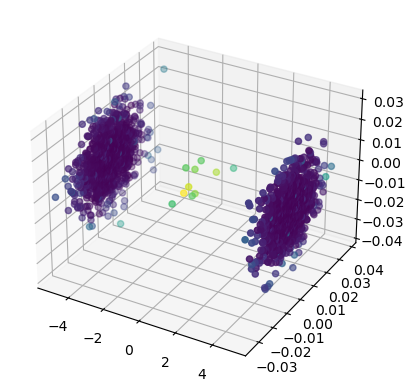

In [7]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=avg_codisp)
plt.show()

In [8]:
'''
Note that the outlier points again have a larger codisp. 
To classify the original points into inlier and outlier classes, 
perform a simple threshold test on the codisp result.
'''
# For example:
print("Is outlier?\n",avg_codisp > avg_codisp.quantile(0.99))

Is outlier?
 0       False
1       False
2       False
3       False
4       False
        ...  
2005     True
2006     True
2007     True
2008     True
2009     True
Length: 2010, dtype: bool


### Robust random cut trees (part IV)
#### Streaming anomaly detection
This example shows how the algorithm can be used to detect anomalies in streaming time series data.

In [9]:
import numpy as np
import rrcf

# Generate a data set (sine wave with an anomaly inside)
n = 730
A = 50
center = 100
phi = 30
T = 2*np.pi/100
t = np.arange(n)
sin = A*np.sin(T*t-phi*T) + center
sin[235:255] = 80

# Set tree parameters
num_trees = 40
shingle_size = 4
tree_size = 256

# Construct again a forest of empty trees
forest = []
for _ in range(num_trees):
    tree = rrcf.RCTree()
    forest.append(tree)

# Insert streaming points into tree and compute anomaly score
# Use the "shingle" generator to create a rolling window
points = rrcf.shingle(sin, size=shingle_size)

# Create a dict to store anomaly score of each point
avg_codisp = {}

# For each shingle...
for index, point in enumerate(points):
    # For each tree in the forest...
    for tree in forest:
        # If tree is above permitted size, drop the oldest point (FIFO)
        if len(tree.leaves) > tree_size:
            tree.forget_point(index - tree_size)
        # Insert the new point into the tree
        tree.insert_point(point, index=index)
        # Compute codisp on the new point and take the average among all trees
        if not index in avg_codisp:
            avg_codisp[index] = 0
        avg_codisp[index] += tree.codisp(index) / num_trees

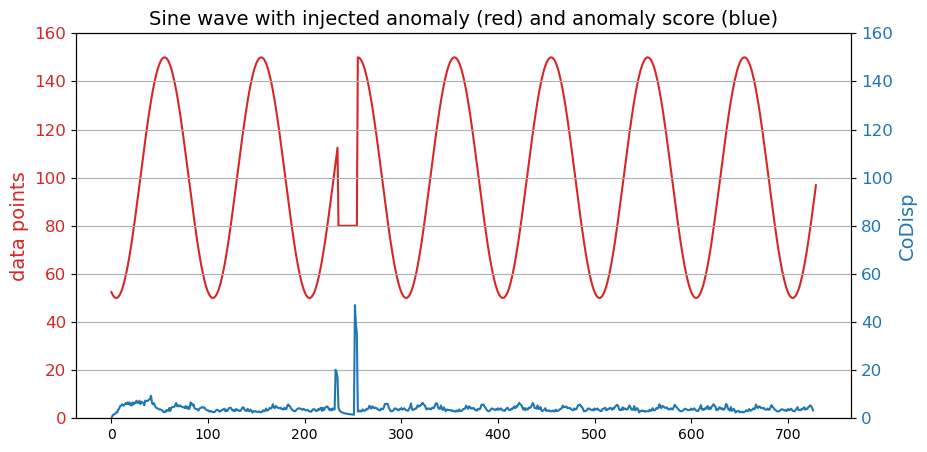

In [10]:
'''visualize the originil time series and the CoDisp score'''
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax1 = plt.subplots(figsize=(10, 5))

color = 'tab:red'
ax1.set_ylabel('data points', color=color, size=14)
ax1.plot(sin, color=color)
ax1.tick_params(axis='y', labelcolor=color, labelsize=12)
ax1.set_ylim(0,160)
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('CoDisp', color=color, size=14)
ax2.plot(pd.Series(avg_codisp).sort_index(), color=color)
ax2.tick_params(axis='y', labelcolor=color, labelsize=12)
ax2.grid('off')
ax2.set_ylim(0, 160)
plt.title('Sine wave with injected anomaly (red) and anomaly score (blue)', size=14)
plt.show()

In [11]:
import pandas as pd

data = pd.read_csv("data/exercise_1/StudentsPerformance.csv")
data.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [12]:
# Select random data from data

def rrcf_anom_detection(data: pd.DataFrame, num_trees: int, tree_size: int, quantile:float) -> pd.DataFrame:
    forest =[]
    for n_tree in range(num_trees): 
        ixs = np.random.choice(data.index, tree_size, replace=False)
        forest.append(rrcf.RCTree(data.loc[ixs].to_numpy().astype(float)[:, np.newaxis], index_labels=ixs))

    codisp_sum = np.zeros_like(data.index).astype(float)
    counter = np.zeros_like(data.index)
    for tree in forest: 
        for leaf in tree.leaves:
            np.add.at(codisp_sum, leaf, tree.codisp(leaf)) 
            np.add.at(counter, leaf, 1)
    if np.any(~counter.astype(bool)): 
        raise ValueError("Not enough trees or tree size too small")
    return  codisp_sum / counter,  codisp_sum / counter > np.quantile((codisp_sum / counter), quantile), np.quantile((codisp_sum / counter), quantile)

score, outlier_label, threshold = rrcf_anom_detection(data["math score"], 300, 300, .995)
data[outlier_label]

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
17,female,group B,some high school,free/reduced,none,18,32,28
59,female,group C,some high school,free/reduced,none,0,17,10
145,female,group C,some college,free/reduced,none,22,39,33
787,female,group B,some college,standard,none,19,38,32
980,female,group B,high school,free/reduced,none,8,24,23


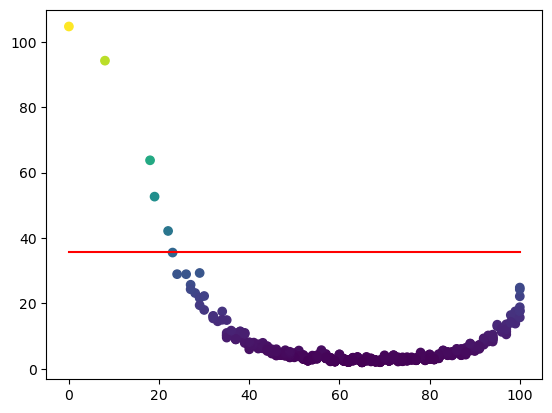

In [13]:
plt.plot([data["math score"].min(), data["math score"].max()], [threshold, threshold], color="r")
plt.scatter(data["math score"], score, c=score)


In [14]:
data = pd.read_csv("data/exercise_1/city_temperature.csv")
data.drop(data[data["AvgTemperature"] == -99].index, inplace=True)
data["AvgTemperature"] = (data["AvgTemperature"] - 32) * 5/9 
data["date"] = pd.to_datetime(data[["Year", "Month", "Day"]])
data = data.set_index("date").groupby(["City", pd.Grouper(freq="D")])["AvgTemperature"].mean()
data = data.reset_index()

/tmp/ipykernel_4887/3201813435.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("data/exercise_1/city_temperature.csv")


In [15]:
p_data = data[data["City"] == "Brasilia"]
score, outlier_label, threshold = rrcf_anom_detection(p_data.reset_index()["AvgTemperature"], 1000, 400, .995)
p_data[outlier_label]

,City,date,AvgTemperature
406288,Brasilia,1996-06-29,13.666667
406289,Brasilia,1996-06-30,14.333333
406632,Brasilia,1997-06-08,15.944444
406633,Brasilia,1997-06-09,15.111111
406771,Brasilia,1997-10-25,28.611111
406842,Brasilia,1998-01-04,27.833333
406925,Brasilia,1998-03-30,28.000000
407080,Brasilia,1998-09-06,30.000000
407223,Brasilia,1999-02-17,28.500000
408563,Brasilia,2002-10-26,30.944444


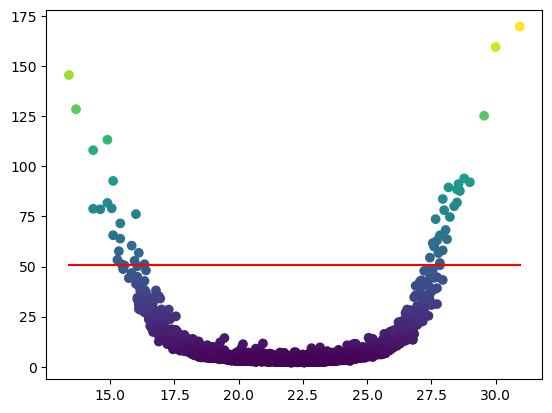

In [16]:
plt.plot([p_data["AvgTemperature"].min(), p_data["AvgTemperature"].max()], [threshold, threshold], color="r")
plt.scatter(p_data["AvgTemperature"], score, c=score)
plt.show()

In [17]:
p_data = data[data["City"] == "Pyongyang"]
score, outlier_label, threshold = rrcf_anom_detection(p_data.reset_index()["AvgTemperature"], 1000, 400, .995)
p_data[outlier_label]

,City,date,AvgTemperature
2008873,Pyongyang,1997-01-21,-14.055556
2009059,Pyongyang,1997-07-26,29.500000
2009060,Pyongyang,1997-07-27,30.111111
2010165,Pyongyang,2000-08-17,31.000000
2010309,Pyongyang,2001-01-11,-17.388889
2010310,Pyongyang,2001-01-12,-18.055556
2010311,Pyongyang,2001-01-13,-17.611111
2010312,Pyongyang,2001-01-14,-19.666667
2010313,Pyongyang,2001-01-15,-20.388889
2010314,Pyongyang,2001-01-16,-19.722222


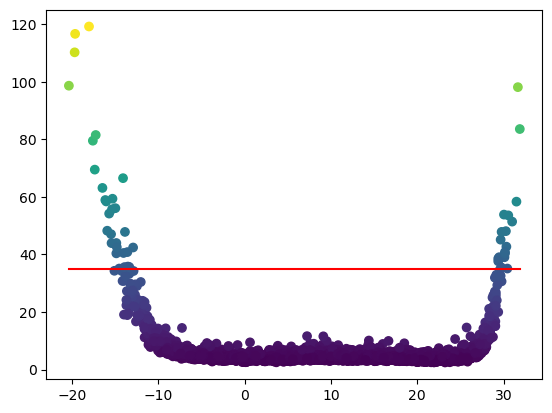

In [18]:
plt.plot([p_data["AvgTemperature"].min(), p_data["AvgTemperature"].max()], [threshold, threshold], color="r")
plt.scatter(p_data["AvgTemperature"], score, c=score)
plt.show()

Just as the Isolation Forest this works well for normally and non-normally distributed dataset to detect outliers. 